# Top Songs on Spotify from 2000 to 2019

In [567]:
# Importing all the Required Libraries

import pandas as pd
import numpy as np
from numpy import mean, std
import datetime as dt
import pickle

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
init_notebook_mode(connected=True)

In [461]:
# Read and extract from the dataset.

df=pd.read_csv('spotify_top_songs.csv')

In [462]:
df.head()

artist                    song  duration_ms  explicit  year  \
0  Britney Spears  Oops!...I Did It Again       211160     False  2000   
1       blink-182    All The Small Things       167066     False  1999   
2      Faith Hill                 Breathe       250546     False  1999   
3        Bon Jovi            It's My Life       224493     False  2000   
4          *NSYNC             Bye Bye Bye       200560     False  2000   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   
3          78         0.551   0.913    0    -4.063     0       0.0466   
4          65         0.614   0.928    8    -4.806     0       0.0516   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018    0.3550    0.894   95.053           pop  
1        0.0103          0.000000    0.6120    0.684  148.726     rock, pop  
2        0.1730          0.000000    0.2510    0.278  136.859  pop, country  
3        0.0263          0.000013    0.3470    0.544  119.992   rock, metal  
4        0.0408          0.001040    0.0845    0.879  172.656           pop

In [463]:
# Shape of the data

df.shape

(2000, 18)

In [76]:
# df = df[(df['popularity'] >= 10)]
# df.loc[df['popularity'] < 10, 'popularity'] = round(df['popularity'].median())

In [464]:
df.loc[(df['genre'].str.contains('set()') | (df['genre'].str.contains('easy listening')) 
        | (df['genre'].str.contains('jazz'))), 'genre'] = 'pop'
df.loc[(df['genre'].str.contains('blues') | df['genre'].str.contains('classical')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('World/Traditional') 
        | df['genre'].str.contains('Folk/Acoustic')), 'genre'] = 'acoustic folk'
df.loc[(df['genre'].str.contains('R&B') & df['genre'].str.contains('pop')), 'genre'] = 'R&B'
df.loc[(df['genre'].str.contains('hip hop') & df['genre'].str.contains('pop')), 'genre'] = 'hip hop'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('pop')), 'genre'] = 'rock'
df.loc[(df['genre'].str.contains('rock') & df['genre'].str.contains('metal')), 'genre'] = 'metal'
df.loc[df['genre'].str.contains('R&B'), 'genre'] = 'R&B'
df.loc[df['genre'].str.contains('hip hop'), 'genre'] = 'hip hop'
df.loc[df['genre'].str.contains('country'), 'genre'] = 'country'
df.loc[df['genre'].str.contains('latin'), 'genre'] = 'latin'
df.loc[df['genre'].str.contains('Dance/Electronic'), 'genre'] = 'EDM'

In [465]:
# Data type of the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


In [466]:
# Checking for null values.

df.isnull().sum()

artist              0
song                0
duration_ms         0
explicit            0
year                0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

In [467]:
# Checking for unique values.

df.nunique()

artist               835
song                1879
duration_ms         1793
explicit               2
year                  23
popularity            76
danceability         565
energy               580
key                   12
loudness            1671
mode                   2
speechiness          837
acousticness        1208
instrumentalness     772
liveness             783
valence              760
tempo               1831
genre                  9
dtype: int64

In [468]:
# Description of the data

df.describe()

duration_ms        year   popularity  danceability       energy  \
count    2000.000000  2000.00000  2000.000000   2000.000000  2000.000000   
mean   228748.124500  2009.49400    59.872500      0.667438     0.720366   
std     39136.569008     5.85996    21.335577      0.140416     0.152745   
min    113000.000000  1998.00000     0.000000      0.129000     0.054900   
25%    203580.000000  2004.00000    56.000000      0.581000     0.622000   
50%    223279.500000  2010.00000    65.500000      0.676000     0.736000   
75%    248133.000000  2015.00000    73.000000      0.764000     0.839000   
max    484146.000000  2020.00000    89.000000      0.975000     0.999000   

               key     loudness         mode  speechiness  acousticness  \
count  2000.000000  2000.000000  2000.000000  2000.000000   2000.000000   
mean      5.378000    -5.512434     0.553500     0.103568      0.128955   
std       3.615059     1.933482     0.497254     0.096159      0.173346   
min       0.000000   -20.514000     0.000000     0.023200      0.000019   
25%       2.000000    -6.490250     0.000000     0.039600      0.014000   
50%       6.000000    -5.285000     1.000000     0.059850      0.055700   
75%       8.000000    -4.167750     1.000000     0.129000      0.176250   
max      11.000000    -0.276000     1.000000     0.576000      0.976000   

       instrumentalness     liveness      valence        tempo  
count       2000.000000  2000.000000  2000.000000  2000.000000  
mean           0.015226     0.181216     0.551690   120.122558  
std            0.087771     0.140669     0.220864    26.967112  
min            0.000000     0.021500     0.038100    60.019000  
25%            0.000000     0.088100     0.386750    98.985750  
50%            0.000000     0.124000     0.557500   120.021500  
75%            0.000068     0.241000     0.730000   134.265500  
max            0.985000     0.853000     0.973000   210.851000

In [469]:
# Correlation of data features

df.corr()

duration_ms  explicit      year  popularity  danceability  \
duration_ms          1.000000  0.123595 -0.316534    0.050617     -0.060057   
explicit             0.123595  1.000000  0.078477    0.046605      0.248845   
year                -0.316534  0.078477  1.000000   -0.003825      0.033532   
popularity           0.050617  0.046605 -0.003825    1.000000     -0.003546   
danceability        -0.060057  0.248845  0.033532   -0.003546      1.000000   
energy              -0.078763 -0.162462 -0.108644   -0.014021     -0.104038   
key                 -0.002560  0.003320  0.007380    0.014823      0.032731   
loudness            -0.079912 -0.089829  0.017479    0.030632     -0.033315   
mode                -0.003848  0.049576 -0.007358   -0.021353     -0.067528   
speechiness          0.066998  0.417343  0.001111    0.021162      0.145590   
acousticness         0.010923 -0.033523  0.033809    0.024619     -0.065429   
instrumentalness    -0.004208 -0.082522 -0.050265   -0.048059      0.023207   
liveness             0.024941  0.008884 -0.027037   -0.009856     -0.126413   
valence             -0.116870 -0.045455 -0.209365   -0.016142      0.403178   
tempo               -0.028603  0.013221  0.076867    0.014288     -0.173418   

                    energy       key  loudness      mode  speechiness  \
duration_ms      -0.078763 -0.002560 -0.079912 -0.003848     0.066998   
explicit         -0.162462  0.003320 -0.089829  0.049576     0.417343   
year             -0.108644  0.007380  0.017479 -0.007358     0.001111   
popularity       -0.014021  0.014823  0.030632 -0.021353     0.021162   
danceability     -0.104038  0.032731 -0.033315 -0.067528     0.145590   
energy            1.000000 -0.003446  0.651016 -0.040651    -0.057018   
key              -0.003446  1.000000 -0.007474 -0.153182     0.007147   
loudness          0.651016 -0.007474  1.000000 -0.028133    -0.076388   
mode             -0.040651 -0.153182 -0.028133  1.000000    -0.000077   
speechiness      -0.057018  0.007147 -0.076388 -0.000077     1.000000   
acousticness     -0.445469  0.002365 -0.310039  0.005744     0.000394   
instrumentalness  0.037861 -0.008173 -0.104925 -0.038613    -0.062954   
liveness          0.156761 -0.033071  0.102159  0.025439     0.061172   
valence           0.334474  0.036977  0.232150 -0.074681     0.073605   
tempo             0.153719 -0.001431  0.080709  0.048434     0.057747   

                  acousticness  instrumentalness  liveness   valence     tempo  
duration_ms           0.010923         -0.004208  0.024941 -0.116870 -0.028603  
explicit             -0.033523         -0.082522  0.008884 -0.045455  0.013221  
year                  0.033809         -0.050265 -0.027037 -0.209365  0.076867  
popularity            0.024619         -0.048059 -0.009856 -0.016142  0.014288  
danceability         -0.065429          0.023207 -0.126413  0.403178 -0.173418  
energy               -0.445469          0.037861  0.156761  0.334474  0.153719  
key                   0.002365         -0.008173 -0.033071  0.036977 -0.001431  
loudness             -0.310039         -0.104925  0.102159  0.232150  0.080709  
mode                  0.005744         -0.038613  0.025439 -0.074681  0.048434  
speechiness           0.000394         -0.062954  0.061172  0.073605  0.057747  
acousticness          1.000000         -0.005214 -0.110043 -0.128128 -0.103660  
instrumentalness     -0.005214          1.000000 -0.034897 -0.015192  0.034608  
liveness             -0.110043         -0.034897  1.000000  0.019040  0.028636  
valence              -0.128128         -0.015192  0.019040  1.000000 -0.025076  
tempo                -0.103660          0.034608  0.028636 -0.025076  1.000000

In [319]:
fig = px.imshow(df.corr(), text_auto=True, height=900, width=900, color_continuous_scale=px.colors.sequential.Greens, 
              aspect='auto', template = 'plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Correlation of Columns</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

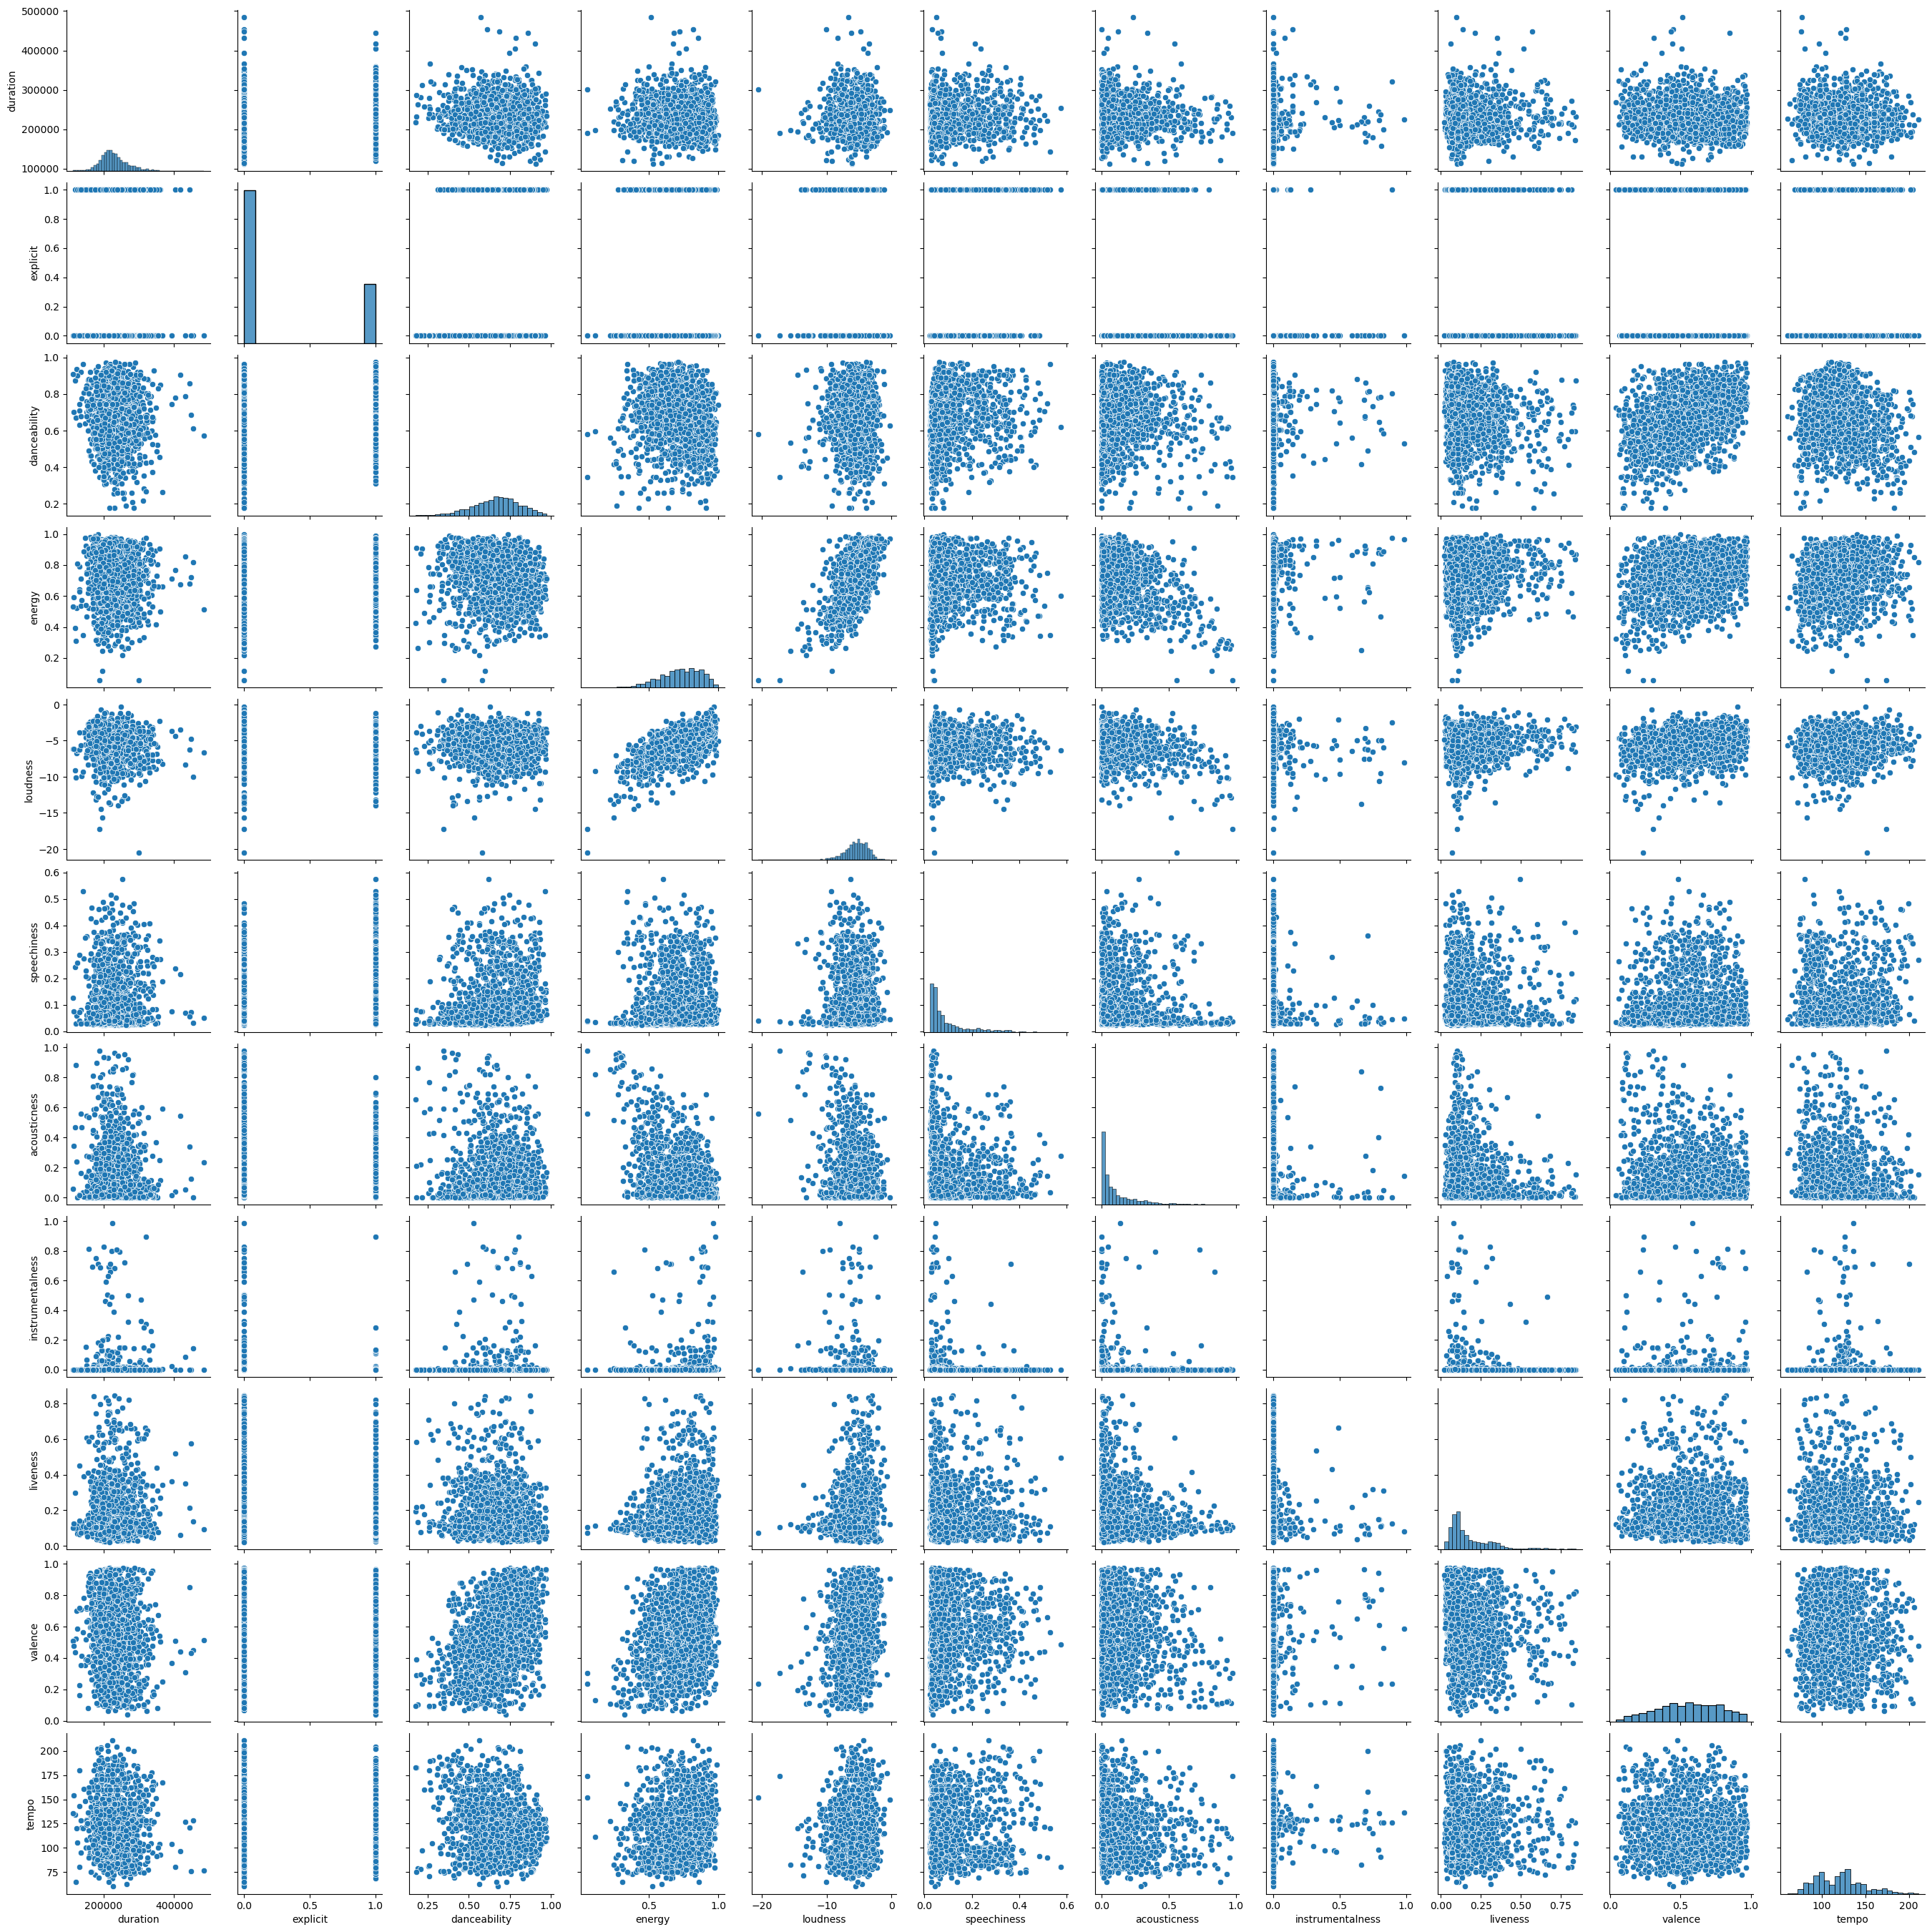

In [14]:
columns = ['duration', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo']
sns.pairplot(df[columns])
plt.show()

In [470]:
fig = px.treemap(df, path=[px.Constant('Singer'), 'artist', 'genre', 'song'], values='popularity', template = 'plotly_dark')
fig.update_traces(root_color='seagreen', textfont_color='white')
fig.update_layout(title_x=0.5, title={'text':'<b>Tree Map of Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [693]:
popular_songs = df.groupby(['artist'])['popularity'].sum()
popular_df = pd.DataFrame({'Artist': popular_songs.index, 
                           'Popularity': popular_songs.values}).sort_values(by='Popularity', ascending=False)
popular_df

Artist  Popularity
628         Rihanna        1803
239          Eminem        1519
219           Drake        1424
127   Calvin Harris        1356
118  Britney Spears        1198
..              ...         ...
685         Silentó           0
705     Storm Queen           0
18              AJR           0
732   The Lumineers           0
417           Kungs           0

[835 rows x 2 columns]

In [694]:
fig = px.bar(df.groupby('artist', as_index=False).sum().sort_values(by='popularity', ascending=False).head(15), 
             x='artist', y='popularity', labels={'popularity':'Popularity', 'artist':'Artist'}, 
             color_discrete_sequence=['limegreen'], text='popularity', template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Top 15 Singers</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [471]:
total_songs = df['artist'].value_counts()
songs_df = pd.DataFrame({'Artist': total_songs.index, 'Song': total_songs.values}).sort_values(by='Song', ascending=False)
songs_df

Artist  Song
0           Rihanna    25
1             Drake    23
2            Eminem    21
3     Calvin Harris    20
4    Britney Spears    19
..              ...   ...
500     Tones And I     1
499      Pedro Capó     1
498       Lil Tecca     1
497           Lunay     1
834    Blanco Brown     1

[835 rows x 2 columns]

In [472]:
fig = px.bar(df.groupby('artist', as_index=False).count().sort_values(by='song', ascending=False).head(50), 
       x='artist', y='song', labels={'song':'Total Songs', 'artist':'Artist'}, color_discrete_sequence=['limegreen'], 
       text='song', template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Number of Songs Recorded by Each Singer</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [700]:
genre_popularity = df.groupby(['year', 'genre'])['popularity'].sum().reset_index()
genre_popularity = genre_popularity[(genre_popularity['year'] != 1998) & (genre_popularity['year'] != 2020)]
genre_popularity

year    genre  popularity
1    1999      EDM         171
2    1999      R&B         512
3    1999  country          66
4    1999  hip hop         301
5    1999    latin         110
..    ...      ...         ...
155  2019      R&B         491
156  2019  hip hop        2086
157  2019    latin         526
158  2019      pop        1576
159  2019     rock          65

[159 rows x 3 columns]

In [706]:
fig = px.line(genre_popularity, x='year', y='popularity', color='genre', template='plotly_dark',
             labels={'year':'Year', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity of Music Genres Across the Years</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [475]:
genre_counts = df['genre'].value_counts()
genre_df = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
genre_df

Genre  Count
0        hip hop    523
1            pop    457
2            R&B    450
3            EDM    263
4           rock    172
5          metal     47
6          latin     43
7  acoustic folk     26
8        country     19

In [476]:
fig = px.pie(genre_df, names='Genre', values='Count', template='plotly_dark', hole=0.4)
fig.update_layout(title_x=0.5, title={'text':'<b>Distribution of Music Genres</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [597]:
fig = px.box(df, x='genre', y='popularity', color='genre', template='plotly_dark', 
             labels={'genre':'Genre', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b> Popular Music Genres</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [328]:
fig=px.pie(df.groupby('explicit', as_index=False).count().sort_values(by='song', ascending=False), names='explicit', 
           values='song', labels={'song':'Total songs', 'explicit':'Explicit'}, hole=.4, 
           color_discrete_sequence=['magenta', 'limegreen'], template='plotly_dark')
fig.update_layout(title_x=0.5, title={'text':'<b>Explicit Content in Songs</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

In [329]:
fig = px.box(df, x='explicit', y='popularity', color='explicit', template='plotly_dark', 
             color_discrete_sequence=['magenta', 'limegreen'], labels={'explicit':'Explicit', 'popularity':'Popularity'})
fig.update_layout(title_x=0.5, title={'text':'<b>Popularity based on explicit content</b>','font':{'size':25}}, 
                  title_font_family="Arial", title_font_color="seagreen")
fig.show()

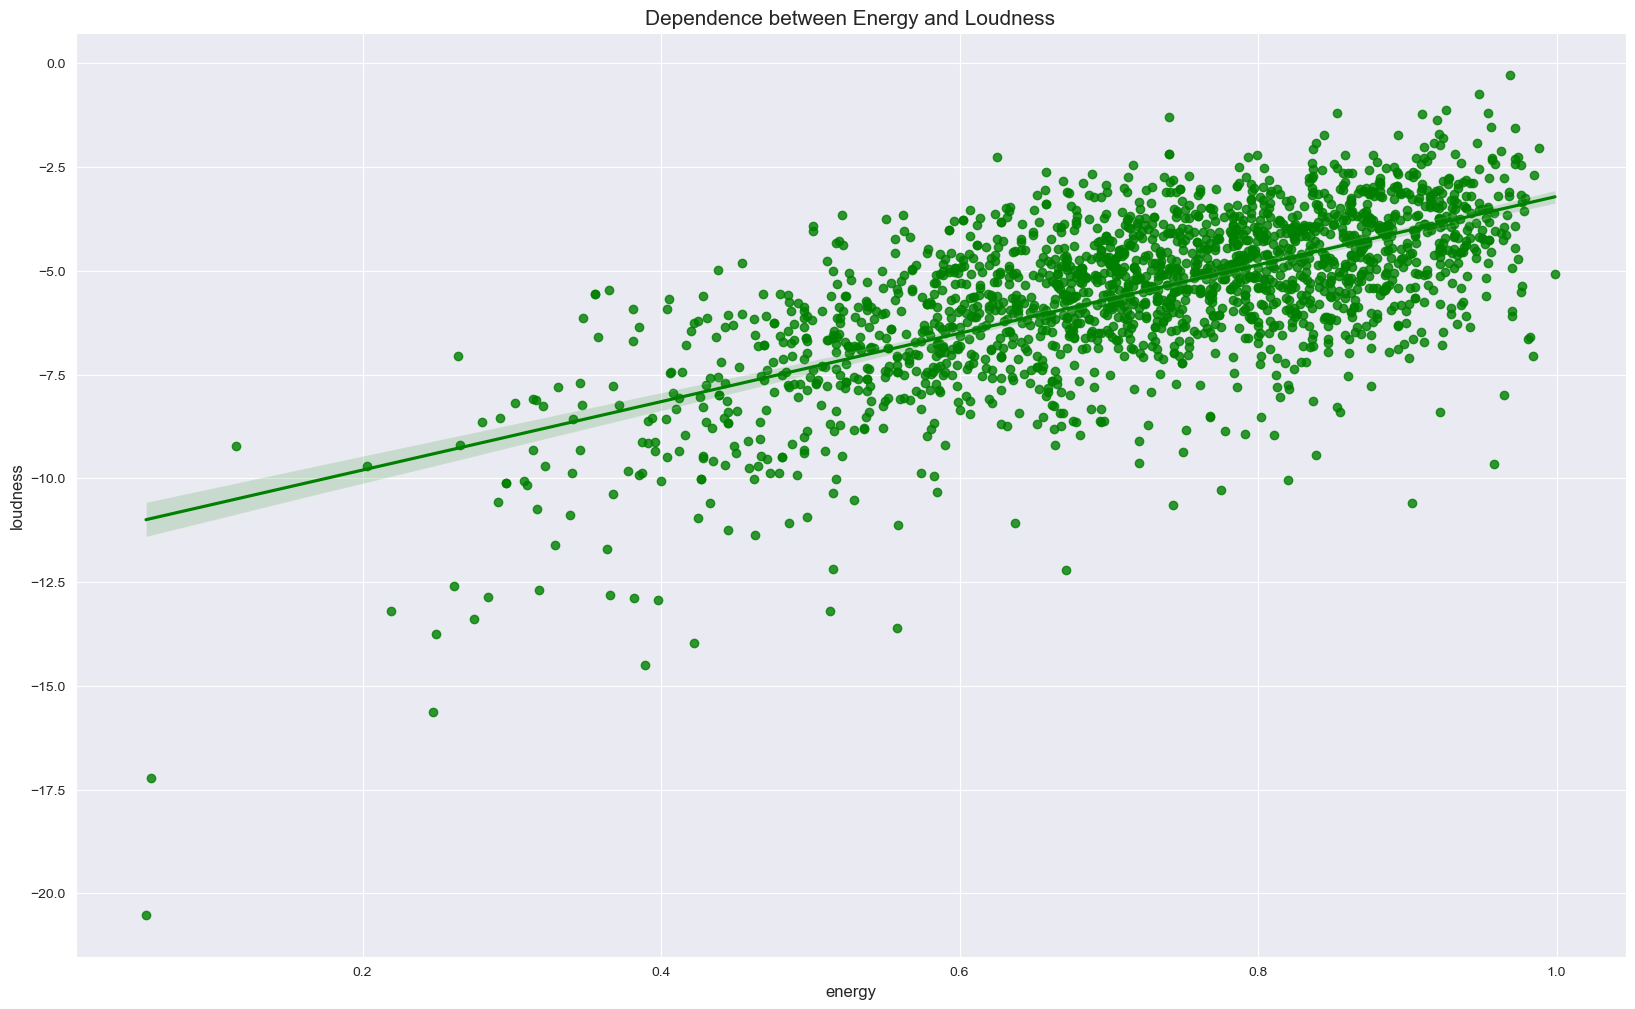

In [330]:
plt.figure(figsize=(20,12))
sns.set_style("darkgrid")
sns.regplot(data=df, x='energy', y='loudness', color='green')
plt.ylabel('loudness', fontsize=12)
plt.xlabel("energy", fontsize=12)
plt.title('Dependence between Energy and Loudness', fontsize=15)
plt.show()

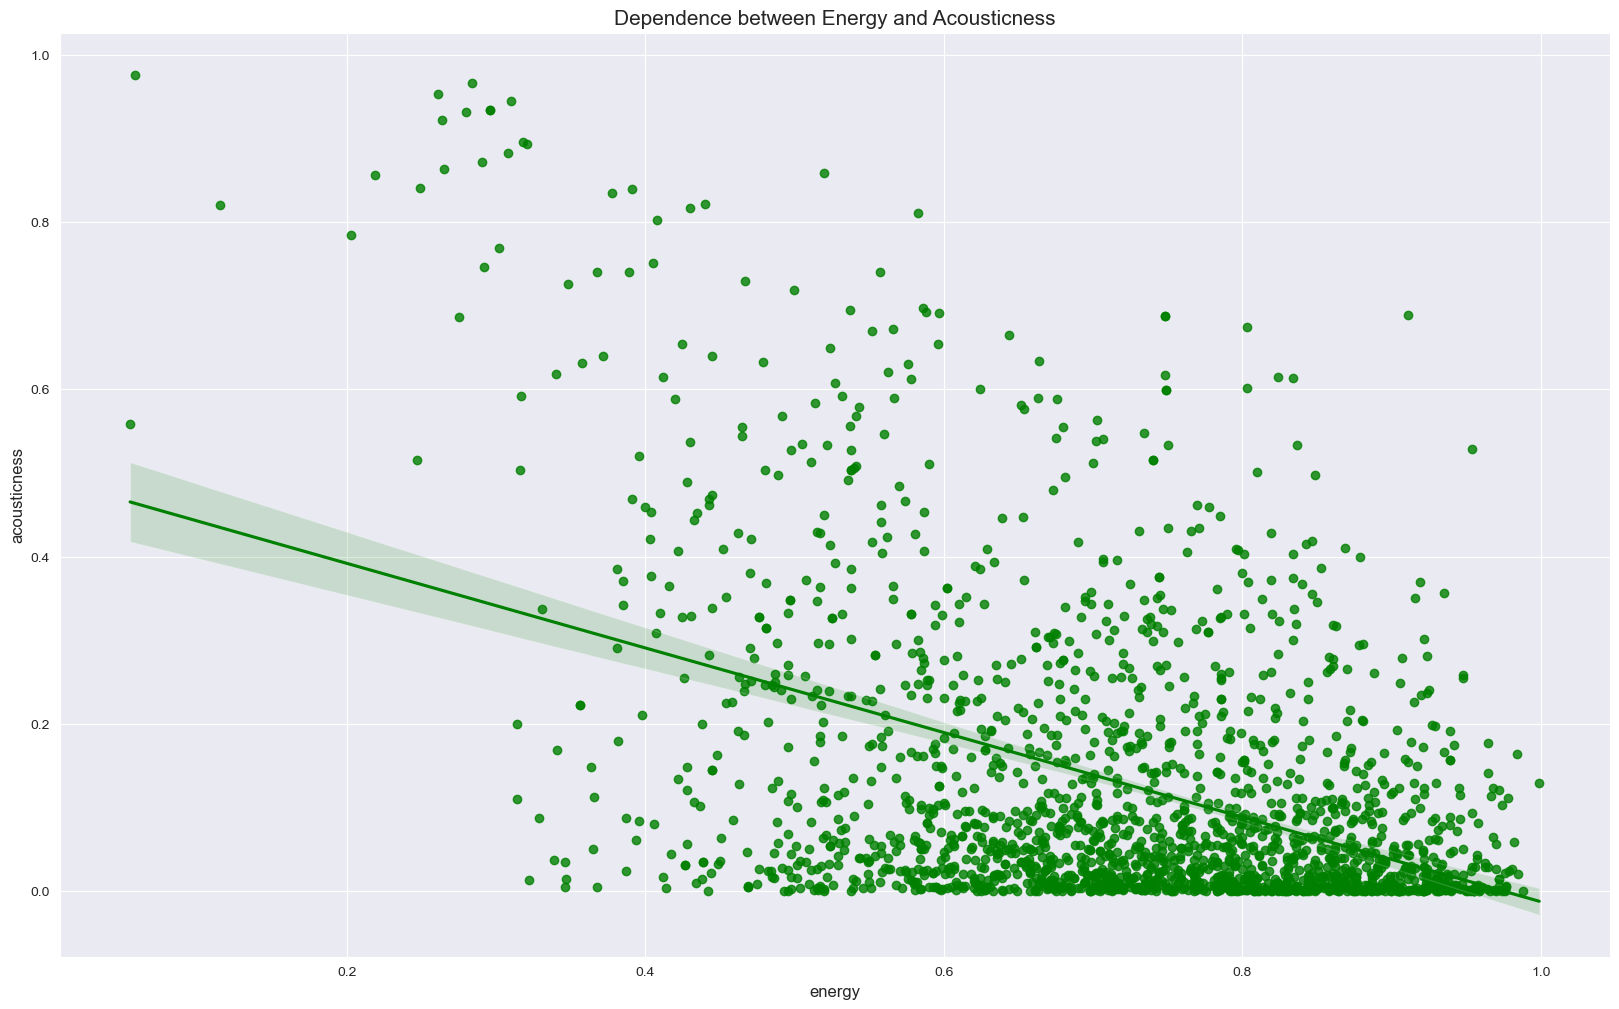

In [668]:
plt.figure(figsize=(20,12))
sns.set_style("darkgrid")
sns.regplot(data=df, x='energy', y='acousticness', color='green')
plt.ylabel('acousticness', fontsize=12)
plt.xlabel("energy", fontsize=12)
plt.title('Dependence between Energy and Acousticness', fontsize=15)
plt.show()

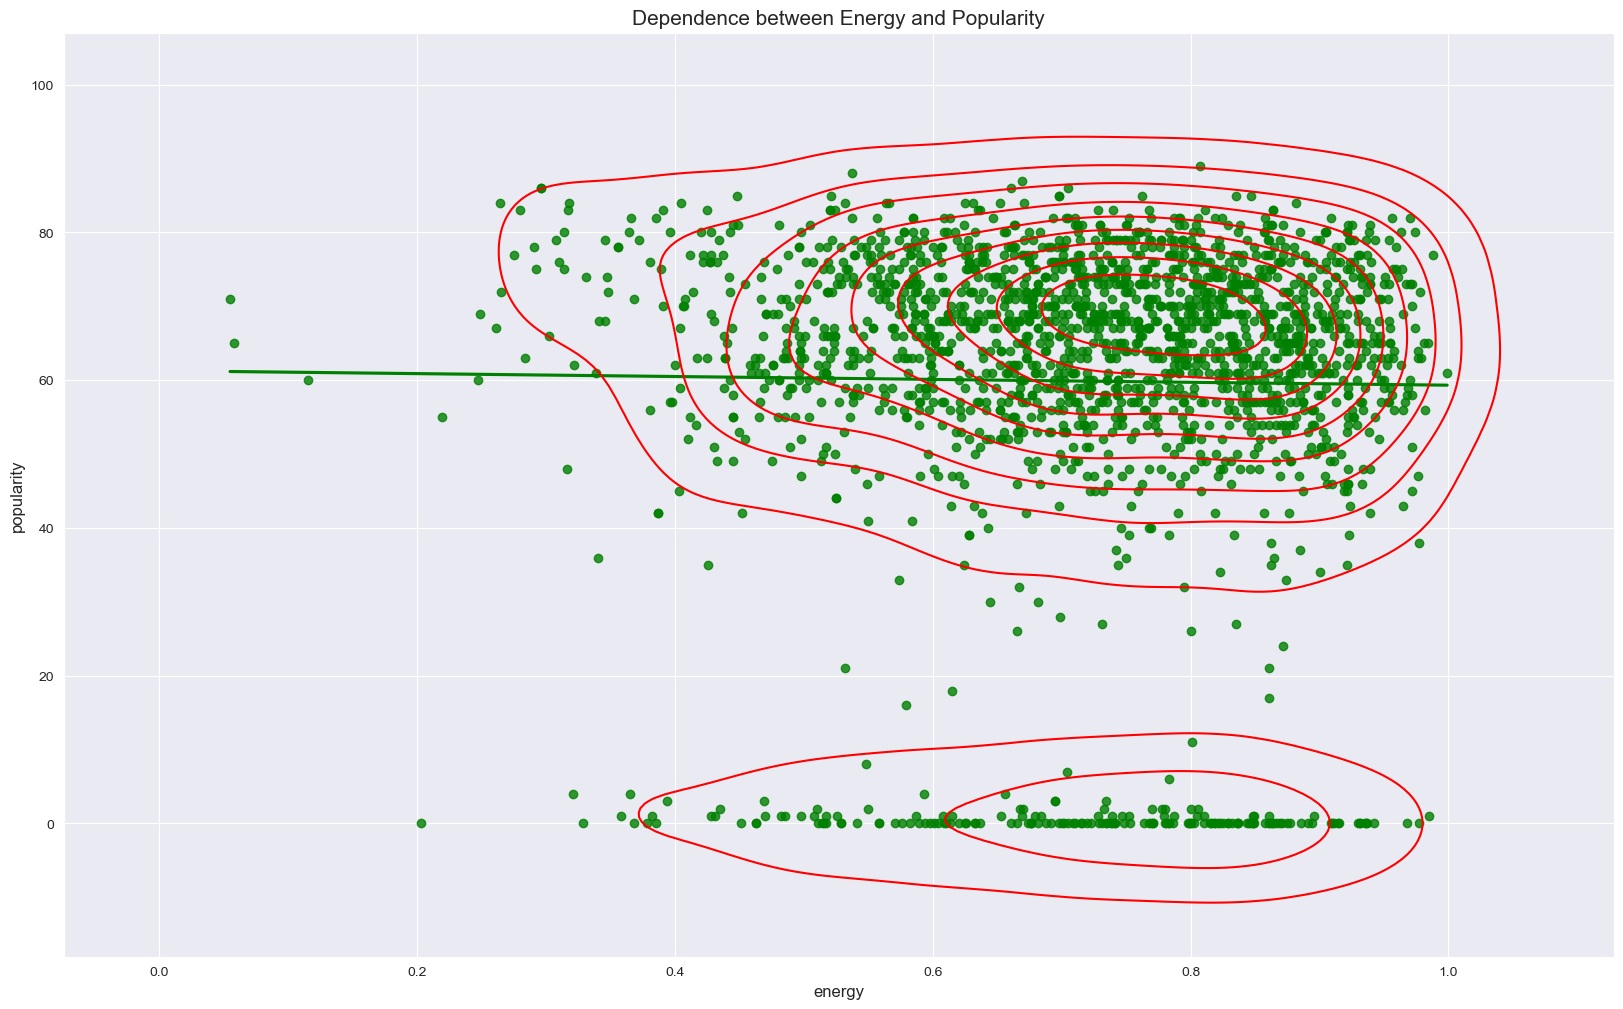

In [331]:
# plt.figure(figsize=(20,12))
# sns.set_style("darkgrid")
# sns.regplot(data=df, x='energy', y='popularity', ci=None, color='green')
# sns.kdeplot(x=df.energy, y=df.popularity, color='red')
# plt.ylabel('popularity', fontsize=12)
# plt.xlabel("energy", fontsize=12)
# plt.title('Dependence between Energy and Popularity', fontsize=15)
# plt.show()

<Figure size 2000x1200 with 0 Axes>

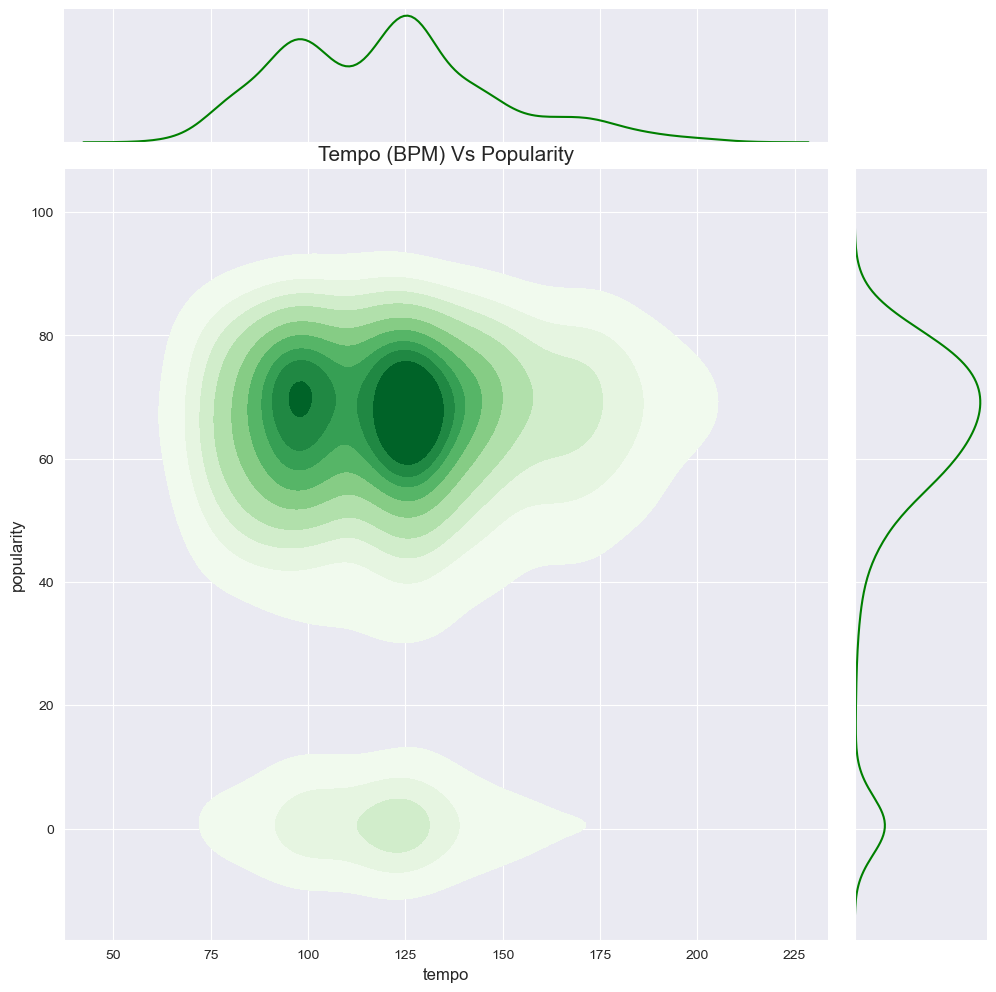

In [332]:
plt.figure(figsize=(20,12))
sns.set_style("darkgrid")
sns.jointplot(data=df, x='tempo', y='popularity', kind="kde", color='green', shade=True, cmap="Greens", height=10)
plt.ylabel('popularity', fontsize=12)
plt.xlabel("tempo", fontsize=12)
plt.title("Tempo (BPM) Vs Popularity", fontsize=15)
plt.show()

In [26]:
# fig=make_subplots(rows=3,cols=3,subplot_titles=('<i>popularity', '<i>danceability', '<i>energy', 
#                                                 '<i>loudness', '<i>speechiness', '<i>acousticness', 
#                                                 '<i>liveness', '<i>valence', '<i>tempo'))
# fig.add_trace(go.Histogram(x=df['popularity'], name='popularity'), row=1, col=1)
# fig.add_trace(go.Histogram(x=df['danceability'], name='danceability'), row=1, col=2)
# fig.add_trace(go.Histogram(x=df['energy'], name='energy'), row=1, col=3)
# fig.add_trace(go.Histogram(x=df['loudness'], name='loudness'), row=2, col=1)
# fig.add_trace(go.Histogram(x=df['speechiness'], name='speechiness'), row=2, col=2)
# fig.add_trace(go.Histogram(x=df['acousticness'], name='acousticness'), row=2, col=3)
# fig.add_trace(go.Histogram(x=df['liveness'], name='liveness'), row=3, col=1)
# fig.add_trace(go.Histogram(x=df['valence'], name='valence'), row=3, col=2)
# fig.add_trace(go.Histogram(x=df['tempo'], name='tempo'), row=3,col=3)
# fig.update_layout(height=900, width=900, title_text='<b>Feature Distribution')
# fig.update_layout(template='plotly_dark', title_x=0.5)

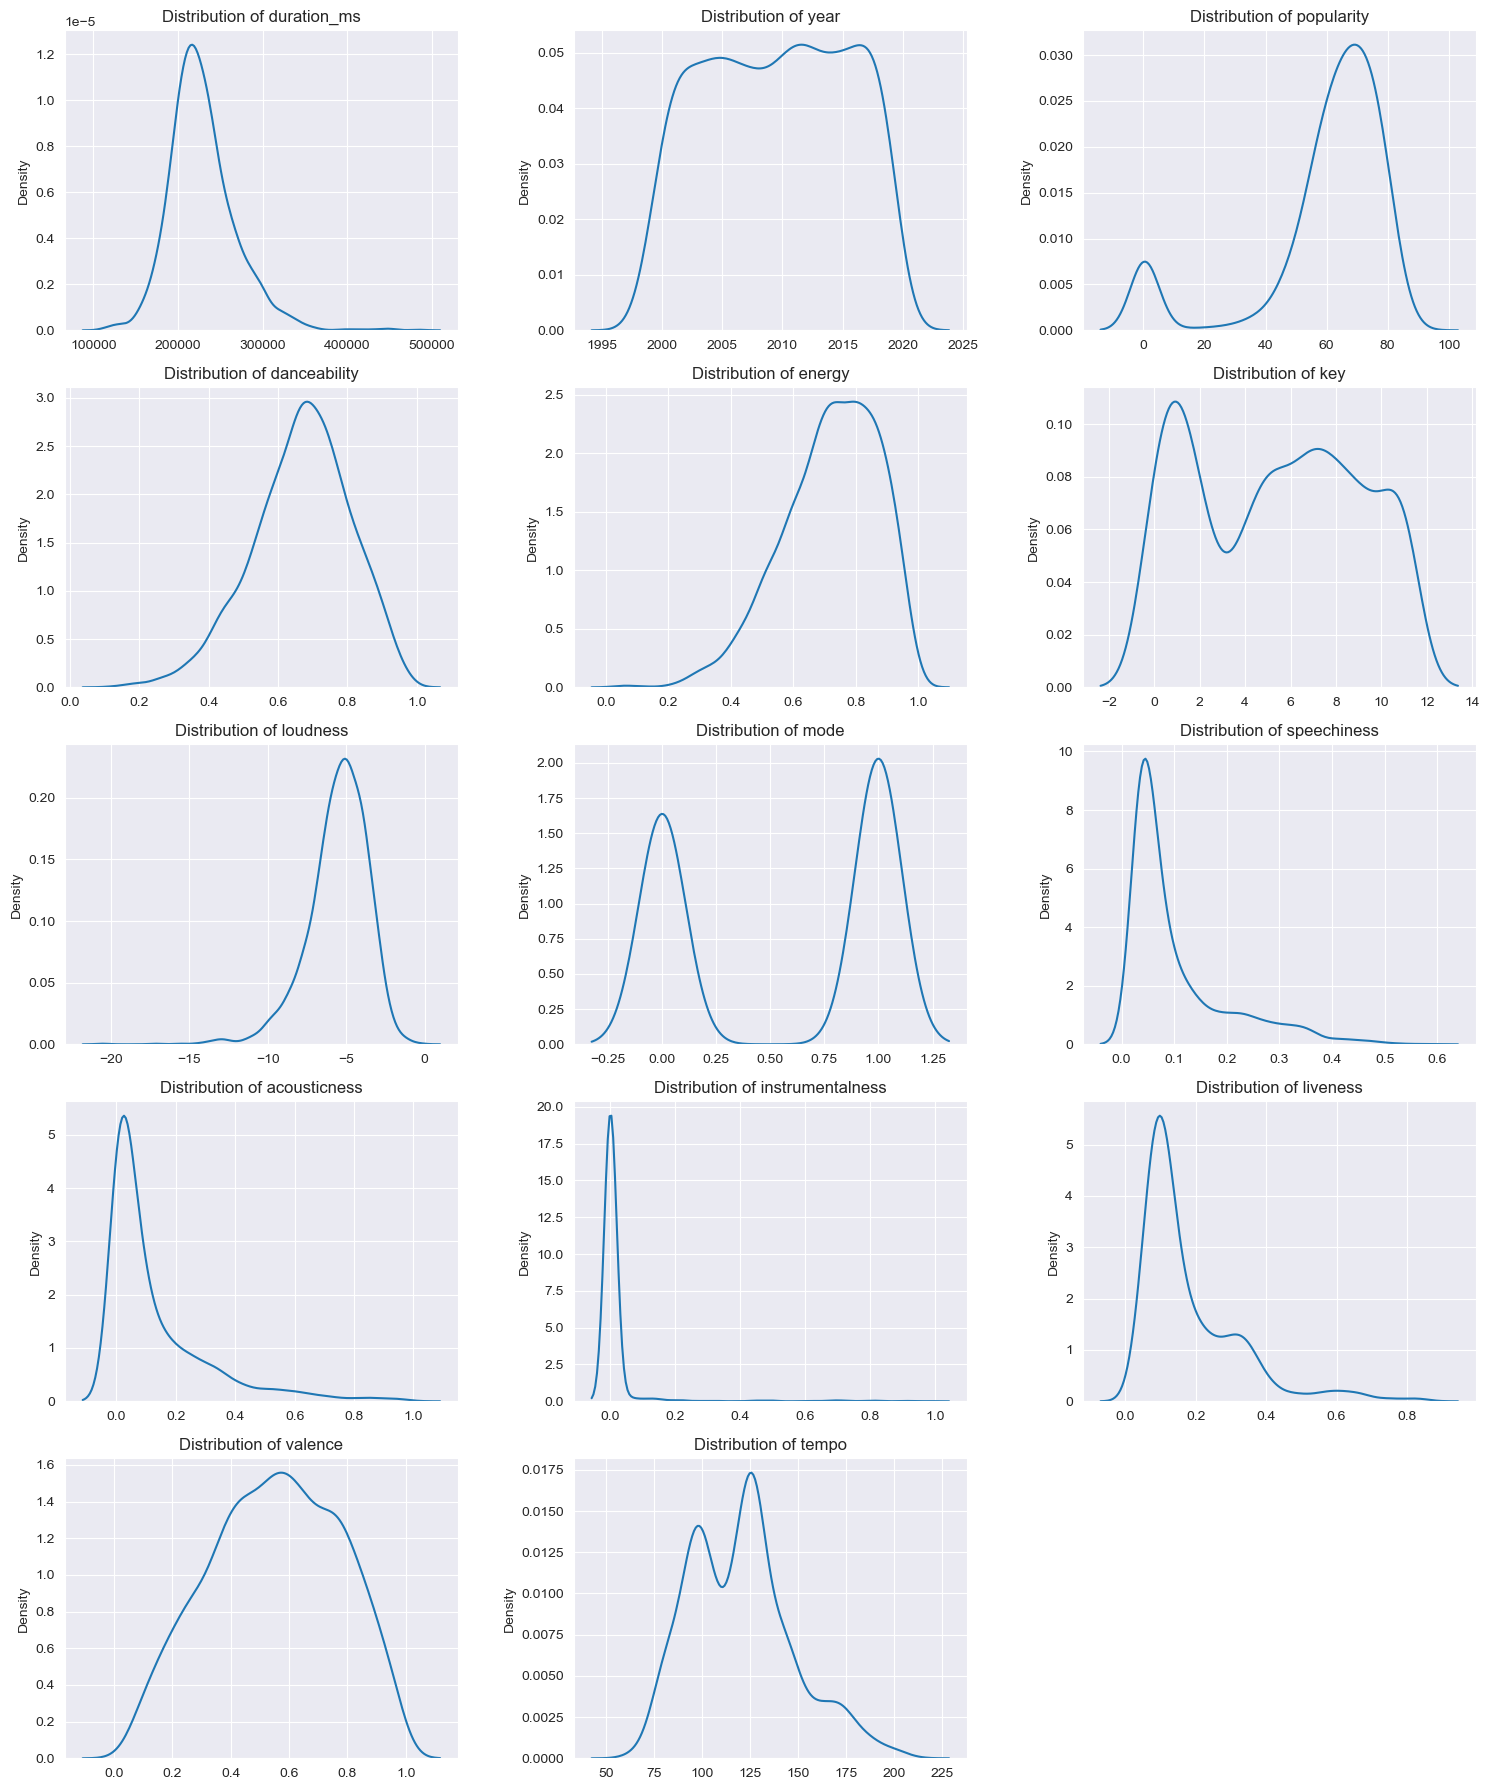

In [333]:
df_cont = df.select_dtypes([int,float]) # store all integer or float columns in df_cont variable
fig = plt.figure(figsize=(15, 18)) # sets the size of the 4 plot with width as 15 and height as 18
for i,columns in enumerate(df_cont.columns, 1): 
    ax = plt.subplot(5,3,i) # creates 3 subplots in one single row
    sns.kdeplot(x=df_cont[columns]) # creates kde plots for each feature in df_cont dataset
    ax.set_xlabel(None) # removes the labels on x-axis
    ax.set_title(f'Distribution of {columns}') # adds a title to each subplot
    plt.tight_layout(w_pad=3) # adds padding between the subplots
plt.show() # displays the plots

In [173]:
df_cont = df.select_dtypes([int,float]) # store all integer or float columns in df_cont variable
for i in df_cont.columns:
    print(f'Skewness in {i} =',df_cont[i].skew())

Skewness in duration_ms = 1.0189247091875024
Skewness in year = -0.04620500473358289
Skewness in popularity = -0.8910940345849971
Skewness in danceability = -0.4280298559347847
Skewness in energy = -0.6328957918712006
Skewness in key = -0.00937928014244139
Skewness in loudness = -1.1998660942904196
Skewness in mode = -0.2153972451166409
Skewness in speechiness = 1.761876968368157
Skewness in acousticness = 2.0941337229464905
Skewness in instrumentalness = 7.581735567613004
Skewness in liveness = 1.8485791438177614
Skewness in valence = -0.12881586250510355
Skewness in tempo = 0.5467700722015391


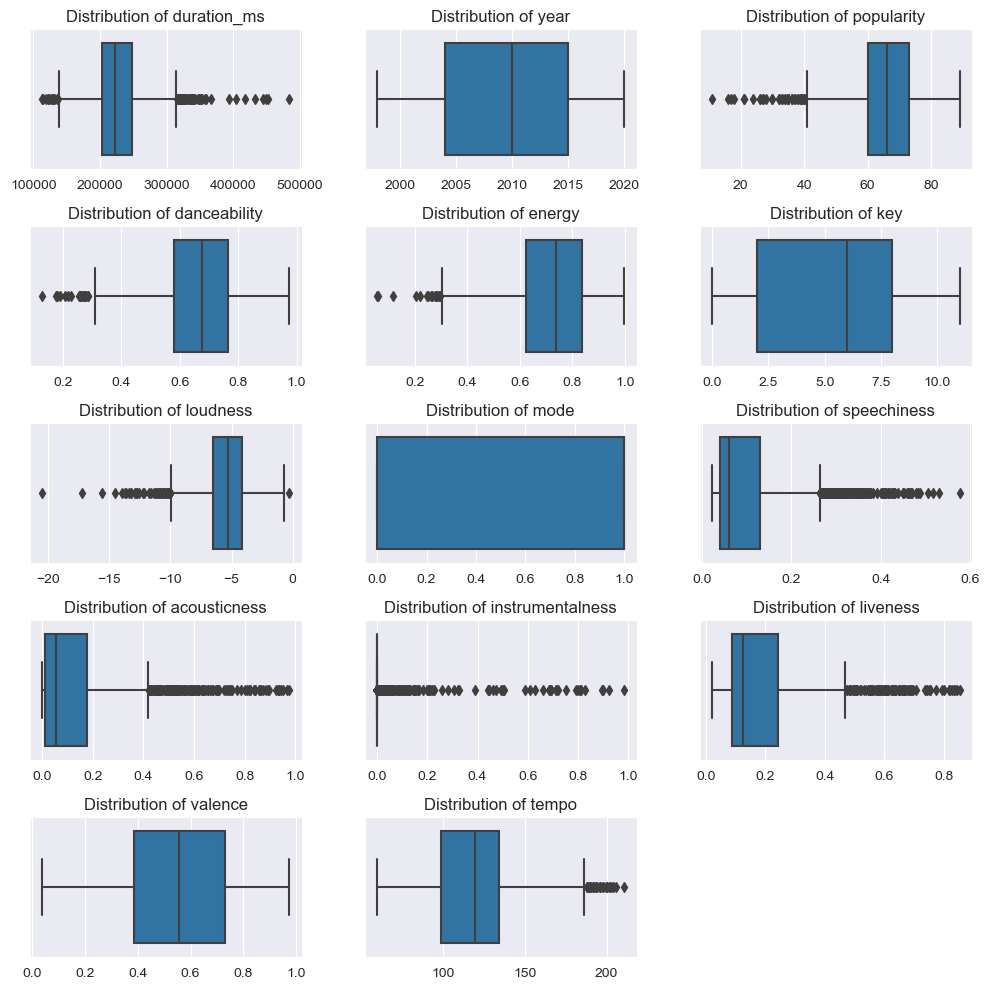

In [174]:
df_cont = df.select_dtypes([int,float]) # store all integer or float columns in df_cont variable
fig = plt.figure(figsize=(10, 10)) # sets the size of the 4 plot with width as 10 and height as 10
for i,columns in enumerate(df_cont.columns, 1): 
    ax = plt.subplot(5,3,i) # creates 3 subplots in one single row
    sns.boxplot(data = df_cont, x=df_cont[columns]) # creates box plots for each feature in df_cont dataset
    ax.set_xlabel(None) # removes the labels on x-axis
    ax.set_title(f'Distribution of {columns}') # adds a title to each subplot
    plt.tight_layout(w_pad=3) # adds padding between the subplots
plt.show() # displays the plots

In [334]:
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
target = ['popularity']

In [337]:
radar_data = {
    'features': features,
    'values': df.sort_values('popularity', ascending=False)[features].head(1)[features].values[0]
}

radar_df = pd.DataFrame(radar_data)
radar_df

features  values
0  danceability  0.6120
1        energy  0.8070
2   speechiness  0.0336
3  acousticness  0.0495
4      liveness  0.1010
5       valence  0.3980

In [338]:
fig = px.line_polar(radar_df, r='values', theta='features', line_close=True)
fig.update_traces(fill='toself')
fig.show()

In [339]:
radar_data = {
    'features': features,
    'values': df.sort_values('popularity', ascending=False)[features].tail(1).values[0]
}

radar_df = pd.DataFrame(radar_data)
radar_df

features  values
0  danceability  0.7070
1        energy  0.8690
2   speechiness  0.0481
3  acousticness  0.1040
4      liveness  0.0813
5       valence  0.6210

In [340]:
fig = px.line_polar(radar_df, r='values', theta='features', line_close=True)
fig.update_traces(fill='toself')
fig.show()

### Machine Learning

In [656]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
target = ['popularity']
X = df[features]
y = df[target]

In [657]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [522]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# from sklearn.decomposition import PCA 
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# explained_variance = pca.explained_variance_ratio_
# explained_variance

In [548]:
model = DecisionTreeRegressor(max_leaf_nodes=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 504.64214006354763
Mean Absolute Error: 15.448253492916129


In [549]:
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_df

Feature  Importance
0      danceability    0.218912
1            energy    0.048091
2          loudness    0.145468
3       speechiness    0.141286
4      acousticness    0.112309
5  instrumentalness    0.121067
6          liveness    0.046438
7           valence    0.166428

In [660]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

with open('popularity_model.h5', 'wb') as file:
    pickle.dump(model, file)

Mean Squared Error: 494.6512430787018
Mean Absolute Error: 15.308513690476191


In [551]:
selector = SelectKBest(k='all')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 512.4694090391666
Mean Absolute Error: 15.650649166666668


In [588]:
selector = SelectFromModel(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                 max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,
                                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                                                 n_estimators=100, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                                 warm_start=False),
                          max_features=None, norm_order=1, prefit=False, threshold='median')

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]
print(selected_features)

model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, max_depth=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Index(['loudness', 'acousticness', 'liveness', 'valence'], dtype='object')
Mean Squared Error: 496.03338428645833
Mean Absolute Error: 15.244117916666667


In [658]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 475.0593054045184
Mean Absolute Error: 14.996972315588224


In [554]:
model = BaggingRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Squared Error: 501.5827167494444
Mean Absolute Error: 15.56538
MAE: -15.155 (1.098)


In [555]:
model = AdaBoostRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 526.8375817360471
Mean Absolute Error: 18.060093718014468


In [556]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 503.0056483448625
Mean Absolute Error: 15.604741086959839


In [557]:
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 506.1927396204199
Mean Absolute Error: 15.459867041297576


In [417]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_train)
y_pred1 = mlp.predict(X_test)
m1 = mean_absolute_error(y_train, y_pred)
m2 = mean_absolute_error(y_test, y_pred1)
print("MAE of MLP Regressor on training set: {:.3f}".format(m1))
print("MAE of MLP Regressor on test set: {:.3f}".format(m2))

MAE of MLP Regressor on training set: 15.122
MAE of MLP Regressor on test set: 15.922


In [661]:
model.predict([df[df['artist'] == 'Rihanna'][features].iloc[20]])

array([72.56])

### Predict the Genre

In [687]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df[target])

In [688]:
label_df = pd.DataFrame({
    'genre': df['genre'],
    'label': encoded_labels
})

label_list = []
for i in label_df.values:
    label_list.append(i)
set(tuple(arr) for arr in label_list)

{('EDM', 0),
 ('R&B', 1),
 ('acoustic folk', 2),
 ('country', 3),
 ('hip hop', 4),
 ('latin', 5),
 ('metal', 6),
 ('pop', 7),
 ('rock', 8)}

In [689]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
target = ['genre']
X = df[features]
y = encoded_labels

In [690]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [691]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

with open('genre_model.h5', 'wb') as file:
    pickle.dump(clf, file)

Accuracy: 0.4325


In [511]:
genre_prediction = clf.predict([df[df['artist'] == 'Marshmello'][features].iloc[1]])
label_encoder.inverse_transform(genre_prediction)

array(['EDM'], dtype=object)

### Streamlit Application

In [692]:
%%writefile app.py

import streamlit as st
import streamlit.components.v1 as components

import pickle

with open('genre_model.h5', 'rb') as genre_file:
    genre_model = pickle.load(genre_file)

with open('popularity_model.h5', 'rb') as model_file:
    model = pickle.load(model_file)
    
labels = [
    {'Genre': 'EDM', 'Label': 0},
    {'Genre': 'R&B', 'Label': 1},
    {'Genre': 'acoustic folk', 'Label': 2},
    {'Genre': 'country', 'Label': 3},
    {'Genre': 'hip hop', 'Label': 4},
    {'Genre': 'latin', 'Label': 5},
    {'Genre': 'metal', 'Label': 6},
    {'Genre': 'pop', 'Label': 7},
    {'Genre': 'rock', 'Label': 8},
]
    
def predict_genre(danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence):
    """
    this method is for predicting genre
    takes all the Audio characteristics that we used for modelling and returns the prediction 
    """
    prediction = genre_model.predict([[danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness,
                                 valence]])
    return prediction[0]

def predict_popularity(danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence):
    """
    this method is for predicting popularity
    takes all the Audio characteristics that we used for modelling and returns the prediction 
    """
    prediction = model.predict([[danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness,
                                 valence]])
    return prediction[0]

def main():
    st.title("Data Analysis Project")
    
#     st.image("https://cdn2.downdetector.com/static/uploads/logo/Spotify_Logo_RGB_Green.png", width=700, use_column_width=False)
    st.image("https://cdn.dribbble.com/users/441326/screenshots/3165191/spotify-gif---oliver-keane.gif", 
             width=700, use_column_width=False)
     
    html_temp2 = """
        <div style="background-color:limegreen; padding:10px;border-radius:10px;">
        <h1 style="color:white;text-align:center;">Predict the Song's Popularity on Spotify</h1>
        </div>
        """
    # can use st.write()
    components.html(html_temp2)
    # components.html() will render the render the html component
        
    danceability = st.number_input("danceability", min_value=0.0, max_value=1.0, step=0.1)
    energy = st.number_input("energy", min_value=0.0, max_value=1.0, step=0.1)
    loudness = st.number_input("loudness", min_value=-60.0, max_value=0.0, step=0.1)
    speechiness = st.number_input("speechiness", min_value=0.00, max_value=1.00, step=0.05)
    acousticness = st.number_input("acousticness", min_value=0.00, max_value=1.00, step=0.05)
    instrumentalness = st.slider('instrumentalness', min_value=0.000000, max_value=1.000000, value=0.000050, step=0.005000)    
    liveness = st.number_input("liveness", min_value=0.00, max_value=1.00, step=0.05)
    valence = st.number_input("valence", min_value=0.00, max_value=1.00, step=0.05)
    
    genre=""
    result=""
    if st.button("Predict"):
        st.table(labels)
        genre = predict_genre(danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence)
        result = predict_popularity(danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, 
                                    valence)
        st.success('The song is a {}'.format(genre))
        st.success('The Popularity of the song is {}'.format(result))

if __name__=='__main__':
    main()

Overwriting app.py
